<center> <img src = https://raw.githubusercontent.com/AndreyRysistov/DatasetsForPandas/main/hh%20label.jpg alt="drawing" style="width:400px;">

# <center> Проект: Анализ вакансий из HeadHunter

<center> [Ссылка на код в NBViewer со всеми графиками](https://nbviewer.org/github/EkaterinaArsa/DS_projects/blob/97db8706f3e00c592ef0a9d0dca343565962d8ea/%D0%90%D0%BD%D0%B0%D0%BB%D0%B8%D0%B7_%D0%B2%D0%B0%D0%BA%D0%B0%D0%BD%D1%81%D0%B8%D0%B9_%D0%BD%D0%B0_HeadHunter2/HHru_analysis_vacancies_sql_python_visualization.ipynb) </center>
   

# 1. Подгрузка необходимых библиотек

In [95]:
# Библиотеки для работы с запросами SQL
import pandas as pd
import sqlalchemy
import psycopg2

from sqlalchemy.sql import text

# Библиотеки для визуализации
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

# Библиотеки для отображения графиков plotly через сайт nbviewer.org
from plotly.offline import plot, iplot, init_notebook_mode
init_notebook_mode(connected=True)
import plotly.io as pio

# 2. Подключение к базе данных

In [96]:
# НЕ ЗАБУДЬ УДАЛИТЬ!!!
DBNAME = '********'
USER = '********'
PASSWORD = '********'
HOST = '********'
PORT = '********'

In [97]:
# создадим функцию для осуществления запроса
def query_func(query):
    url = f'postgresql+psycopg2://{USER}:{PASSWORD}@{HOST}:{PORT}/{DBNAME}'
    engine = sqlalchemy.create_engine(url)

    # запуск запроса
    with engine.connect().execution_options(autocommit=True) as conn:
        return pd.read_sql(sql=text(query), con = conn)

# 3. Предварительный анализ данных

1. Запрос, который посчитает количество вакансий в нашей базе (вакансии находятся в таблице vacancies). 

In [98]:
# текст запроса
query_3_1 = 'SELECT count(id) cnt FROM public.vacancies'

In [99]:
# результат запроса
display(query_func(query_3_1)['cnt'][0])


49197

Ответ: общее количество вакансий - 49197 (в таблице vacancies).

2. Запрос, который посчитает количество работодателей (в таблице employers). 

In [100]:
# текст запроса
query_3_2 = 'SELECT count(distinct id) cnt FROM public.employers'

In [101]:
# результат запроса
display(query_func(query_3_2)['cnt'][0])

23501

Ответ: общее количество работодателей - 23501 (таблица employers).

3. Запрос, определяющий количество регионов (таблица areas).

In [102]:
# текст запроса
query_3_3 = 'SELECT count(distinct id) cnt FROM public.areas'

In [103]:
# результат запроса
display(query_func(query_3_3)['cnt'][0])

1362

Ответ: общее количество регионов - 1362 (таблица areas).

4. Запрос, определяющий количество сфер деятельности в базе (таблица industries).

In [104]:
# текст запроса
query_3_4 = 'SELECT count(distinct id) cnt FROM public.industries'

In [105]:
# результат запроса
display(query_func(query_3_4)['cnt'][0])

294

Ответ: общее количество сфер деятельности - 294 (таблица industries).

***

## Выводы по предварительному анализу данных: 
- В представленной нам схеме (public) в базе данных (project_sql) 5 таблиц: vacancies, employers, areas, industries и employers_industries. В них   представлены данные по 49197 вакансиям(согласно таблице vacancies), 23501 работодателям (согласно таблице employers), 1362 регионам (городам) (согласно таблице areas) и 294 сферам деятельности (согласно таблице industries). Таблица employers_industries вспомогательная и демонстрирует связь между работодателями и сферами их деятельности.

# 4. Детальный анализ вакансий

1. Запрос, позволяющий узнать, сколько (cnt) вакансий в каждом регионе (area).
Отсортируйте по количеству вакансий в порядке убывания.

In [106]:
# текст запроса
query_4_1 = 'SELECT a.name area, count(v.id) cnt \
            FROM public.vacancies v \
                JOIN public.areas a ON v.area_id = a.id \
            GROUP BY a.name \
            ORDER BY count(v.id) DESC'

In [107]:
# результат запроса
area_vac_df = query_func(query_4_1)
display(area_vac_df)


,area,cnt
0,Москва,5333
1,Санкт-Петербург,2851
2,Минск,2112
3,Новосибирск,2006
4,Алматы,1892
...,...,...
764,Тарко-Сале,1
765,Новоаннинский,1
766,Бирск,1
767,Сасово,1


In [108]:
# ДОПОЛНИТЕЛЬНО!
# визуализируем некоторые данные (ТОП-10)
area_vac_data = area_vac_df.head(10).copy()

box_area= px.histogram(data_frame=area_vac_data,
                              x='area',
                              y='cnt',
                              color='area',
                              nbins=20,
                              width=700,
                              height=400,
                              title='Количество вакансий в регионах (ТОП-10)')

box_area.show()


Ответ: В  ТОП-10 регионов по количеству вакансий вошли: Москва - 5333 вакансии, Санкт-Питербург - 2851 вакансия, Минск - 2112 вакансий, Новосибирск - 2006 вакансий, Алма-Аты - 1892 вакансии, Екатеринбург - 1698 вакансий, Нижний Новгород - 1670 вакансий, Казань - 1415 вакансий, Краснодар -1301 вакансия, Самара - 1144 вакансии.

2. Напишите запрос, чтобы определить у какого количества вакансий заполнено хотя бы одно из двух полей с зарплатой.

In [109]:
# текст запроса
query_4_2 = 'SELECT count(id) cnt \
            FROM public.vacancies \
            WHERE salary_from is not NULL or salary_to is not NULL'

In [110]:
# результат запроса
display(query_func(query_4_2)['cnt'][0])

24073

In [111]:
# ДОПОЛНИТЕЛЬНО!
# создадим DF (наличие и отсутствие указаний на уровень ЗП) для визуализации
query_4_2_2 = "(SELECT 'Указана' salary, count(id) cnt \
            FROM public.vacancies \
            WHERE salary_from is not NULL or salary_to is not NULL)\
            UNION\
               (SELECT 'Не указана', count(id)\
            FROM public.vacancies \
            WHERE salary_from is NULL and salary_to is NULL)"
            
salary_info = query_func(query_4_2_2)

fig = go.Figure()
fig.add_trace(go.Pie(values=salary_info['cnt'], labels=salary_info['salary']))
fig.update_layout(height=400, 
                  width = 600,
                  legend_orientation="h",
                  legend=dict(x=.5, xanchor="center"),
                  title='Наличие указанной зарплаты в вакансии')
fig.show()

display(salary_info)

,salary,cnt
0,Не указана,25124
1,Указана,24073


Ответ: Заработная плата (нижний и/или верхний предел) указана менее, чем в половине вакансий (24073 (48.9%) - указана, 25124 (51.1%) - не указана).

3. Найдите средние значения для нижней и верхней границы зарплатной вилки. Округлите значения до целого.

In [112]:
# текст запроса
query_4_3 = 'SELECT salary_from min_salary, salary_to max_salary \
            FROM public.vacancies'

In [113]:
# результат запроса
salary_df = query_func(query_4_3)

display(round(salary_df['min_salary'].mean(), 0), round(salary_df['max_salary'].mean(), 0))

71065.0

110537.0

In [114]:
# ДОПОЛНИТЕЛЬНО!
# визуализируем уровни указанной зарплаты

salary_box = go.Figure()
salary_box.add_trace(go.Box(x=salary_df['min_salary'], name='Нижний уровень'))
salary_box.add_trace(go.Box(x=salary_df['max_salary'], name='Верхний уровень'))
salary_box.update_layout(height=400, 
                  width = 600,
                  legend_orientation="h",
                  legend=dict(x=.5, xanchor="center"),
                  title='Уровень указанной зарплаты в вакансии')
salary_box.show()


Ответ: 
Средний уровень зарплаты указанный в вакансиях составил 71065 (медиана 50000) и 110537 (медиана 80000) рублей. ! Но учитывая большое количество вакансий с неуказанными уровнями предполагаемой зарплаты, данные цифры нуждаются в дальнейшей корректировке и изучении.!

 При этом минимальное значение нижнего уровня составило 30 рублей (явный выброс), а максимамальное 1 млн рублей. Следует отметить, что показатели более 360 тысяч следует оценить на отнесение в категорию "выбросы"). Минимальное значение верхнего уровня составило 60 рублей (явный выброс), а максимамальное 1 млн рублей. Следует отметить, что показатели более 450 тысяч следует оценить на отнесение в категорию "выбросы")

4. Напишите запрос, который выведет количество вакансий для каждого сочетания типа рабочего графика (schedule) и типа трудоустройства (employment), используемого в вакансиях. Результат отсортируем по убыванию количества.

In [115]:
# текст запроса
query_4_4 = 'SELECT schedule, employment, count(id) cnt \
            FROM public.vacancies \
            GROUP BY schedule, employment \
            ORDER BY count(id) DESC'

In [116]:
# результат запроса
shed_empl_df = query_func(query_4_4)
display(shed_empl_df)

,schedule,employment,cnt
0,Полный день,Полная занятость,35367
1,Удаленная работа,Полная занятость,7802
2,Гибкий график,Полная занятость,1593
3,Удаленная работа,Частичная занятость,1312
4,Сменный график,Полная занятость,940
5,Полный день,Стажировка,569
6,Вахтовый метод,Полная занятость,367
7,Полный день,Частичная занятость,347
8,Гибкий график,Частичная занятость,312
9,Полный день,Проектная работа,141


employment,Полная занятость,Проектная работа,Стажировка,Частичная занятость
schedule,,,,
Вахтовый метод,367.0,2.0,NaN,NaN
Гибкий график,1593.0,18.0,116.0,312.0
Полный день,35367.0,141.0,569.0,347.0
Сменный график,940.0,1.0,12.0,101.0
Удаленная работа,7802.0,133.0,64.0,1312.0


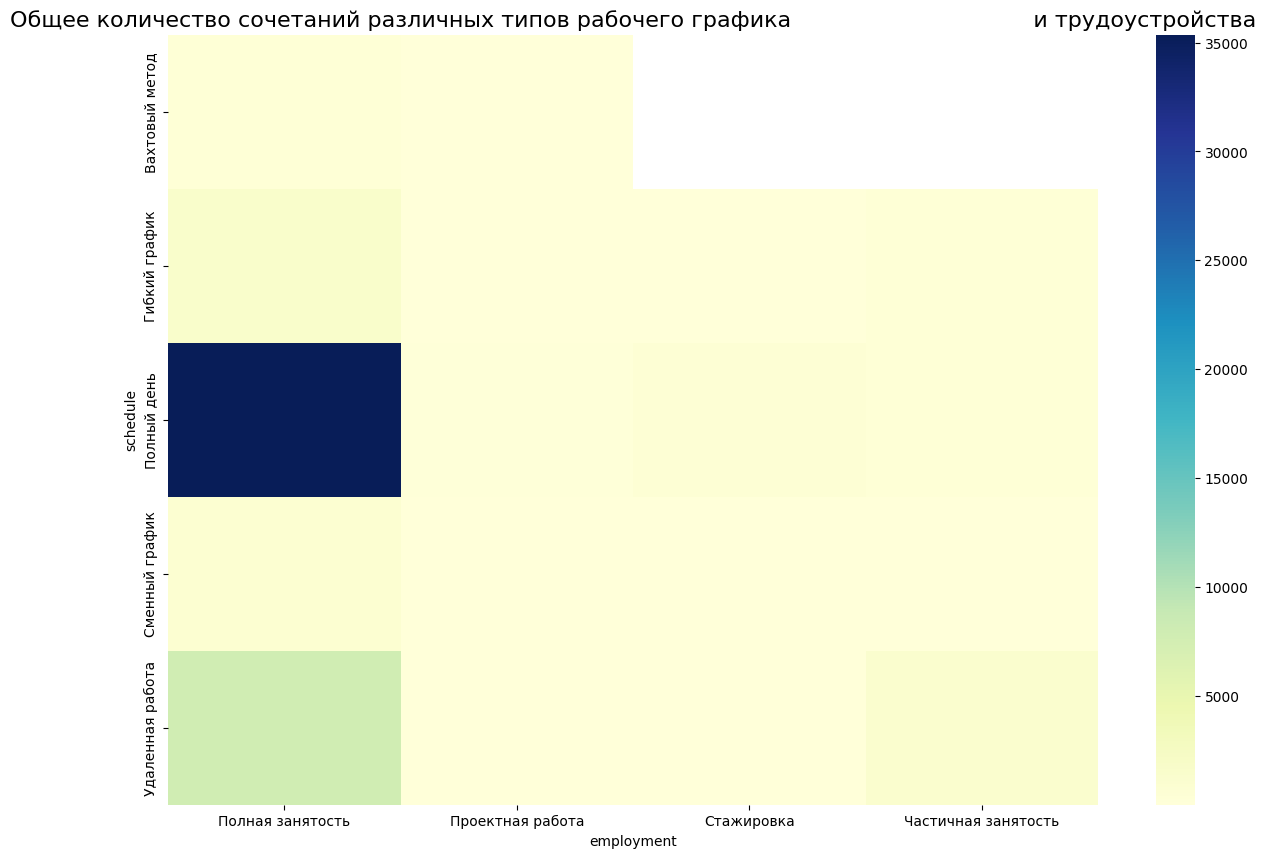

In [117]:
# ДОПОЛНИТЕЛЬНО!
# создадим сводную таблицу и визуализируем ее результаты
pivot_shed_empl = shed_empl_df.pivot_table(values='cnt', 
                                   index='schedule', 
                                   columns='employment', 
                                   aggfunc='sum')

display(pivot_shed_empl)

plt.figure(figsize=(15,10))

heatmap_pivot_shed_empl = sns.heatmap(data=pivot_shed_empl,
                                   cmap='YlGnBu')
heatmap_pivot_shed_empl.set_title('Общее количество сочетаний различных типов рабочего графика\
                                  и трудоустройства',
                                  fontsize=16);

Ответ: Получилось 18 вариантов сочетания типов рабочего графика и занятости. Наибольшее число работодателей предлагает полную занятость при полном рабочем дне (35367 вакансий), значительно меньше (7802 вакансии) - полную занятость при удаленной работе. При частичной занятости в большей мере предлагают удаленную работу. Вахтовый тип рабочего графика не предлагается при стажировке и частичной занятости.

5. Напишите запрос, выводящий значения поля Требуемый опыт работы (experience) в порядке возрастания количества вакансий, в которых указан данный вариант опыта. 

In [118]:
# текст запроса
query_4_5 = 'SELECT experience, count(id) cnt \
            FROM public.vacancies \
            GROUP BY experience \
            ORDER BY count(id)'

In [119]:
# результат запроса
exp_df = query_func(query_4_5)
display(exp_df)

,experience,cnt
0,Более 6 лет,1337
1,Нет опыта,7197
2,От 3 до 6 лет,14511
3,От 1 года до 3 лет,26152


In [120]:
# ДОПОЛНИТЕЛЬНО!
# визуализируем данные по уровню необходимого опыта
pie_exp = go.Figure()
pie_exp.add_trace(go.Pie(values=exp_df['cnt'], labels=exp_df['experience']))
pie_exp.update_layout(height=400, 
                  width = 600,
                  legend_orientation="h",
                  legend=dict(x=.5, xanchor="center"),
                  title='Распределение требований к длительности опыта')
pie_exp.show()

Ответ: Большинство работодателей ищут соискателей с опытом 1-3 года (53.2%, 26153 вакансии), реже необходим опыт от 3 до 6 лет (29.5%, 14511 вакансий), в 14.6% (7197 вакансий) готовы рассмотреть соискателей, неимеющих опыта работы. Опыт работы более 6 лет требуется редко (2.72%, 1337 вакансий). !Интересно посмотреть, как тип грабочего графика и занятости связан с требуемым опытом и влияет на зарплату!

***

## Выводы по детальному анализу вакансий: 
- Наибольшее количество вакансий приходится на  крупные города. В . ТОП-5 вошли: по России: Москва - 5333 вакансии, Санкт-Питербург - 2851 вакансия, Новосибирск - 2006 вакансий; по СНГ Минск - 2112 вакансий, Алма-Аты - 1892 вакансии.

- Более, чем в половине случаев (24073 из 49197), в вакансиях указан минимальный и/или максимальный уровень предполагаемой заработной платы.

- Средние значения "зарплатной вилки" находятся в интервале от 71065 до 110537. Но учитывая большое количество вакансий с неуказанными уровнями предполагаемой зарплаты, данные цифры нуждаются в дальнейшей корректировке и изучении. Кроме того, по данному признаку, вероятно, имеются множественные выбросы.

- Большая часть вакансий предусматривает полный рабочий день и полную занятость (35367 вакансий), меньше предлагают удаленную работу при полной занятости (7802 вакансии). Вахтовый тип рабочего графика не предлагается при стажировке и частичной занятости. !Интересно посмотреть, как тип грабочего графика и занятости связан с требуемым опытом и влияет на зарплату!.

- Требуемый опыт работы преимущественно в интервале 1-3 года (53.2%, 26152 вакансии), реже - 3-6 лет (29.5%, 14511 вакансий). Без опыта работы соискателей готовы принять в 7197 случаев (14.6%), в 1337 вакансиях требуется опыт работы более 6 лет (2.72%).

# 5. Анализ работодателей

1. Напишите запрос, который позволит узнать, какие работодатели находятся на первом и пятом месте по количеству вакансий.

In [121]:
# текст запроса
query_5_1 = 'SELECT e.name employer, count(v.id) cnt \
            FROM public.vacancies v \
                JOIN public.employers e ON v.employer_id = e.id \
            GROUP BY e.name \
            ORDER BY count(v.id) DESC \
            LIMIT 5'

In [122]:
# результат запроса
display(query_func(query_5_1))

,employer,cnt
0,Яндекс,1933
1,Ростелеком,491
2,Тинькофф,444
3,СБЕР,428
4,Газпром нефть,331


In [123]:
# ДОПОЛНИТЕЛЬНО!
# создадим запрос и визуализируем количество вакансий для ТОП-10 работодателей
query_5_1_2 = 'SELECT e.name employer, count(v.id) cnt \
            FROM public.vacancies v \
                JOIN public.employers e ON v.employer_id = e.id \
            GROUP BY e.name \
            ORDER BY count(v.id) DESC \
            LIMIT 10'
            
employers_vac_df = query_func(query_5_1_2)

box_employers_vac= px.histogram(data_frame=employers_vac_df,
                              x='employer',
                              y='cnt',
                              color='employer',
                              nbins=20,
                              width=700,
                              height=400,
                              title='Количество вакансий (ТОП-10 работодателей)')

box_employers_vac.show()

Ответ: Наибольшее количество вакансий предлагается от компании Яндекс (1933). Количество вакансий от других работодателей значительно меньше и не превышает 491 вакансию. В ТОП-10 по количеству вакансий также вошли Ростелеком, Тинькофф, СБЕР, Газпром нефть, ИК СИБИНТЕК, МТС, DataArt, Совкомбанк Технологии, Первый Бит.
!Интересно посмотреть на то, какие вакансии представлены в Яндекс (требуемый опыт, графики работы и занятость)!

2. Напишите запрос, который для каждого региона выведет количество работодателей и вакансий в нём.
Среди регионов, в которых нет вакансий, найдите тот, в котором наибольшее количество работодателей.


In [124]:
# текст запроса
query_5_2 = 'SELECT a.name area, count(e.id) emloyers, count(v.id) vacancies \
            FROM public.areas a \
               LEFT JOIN public.employers e ON a.id = e.area \
               LEFT JOIN public.vacancies v ON a.id = v.area_id \
            GROUP BY a.name \
            HAVING count(v.id) = 0 \
            ORDER BY count(e.id) DESC\
            Limit 10'

In [125]:
# результат запроса
area_vac_df = query_func(query_5_2)
display(area_vac_df)

,area,emloyers,vacancies
0,Россия,410,0
1,Казахстан,207,0
2,Московская область,75,0
3,Краснодарский край,19,0
4,Ростовская область,18,0
5,Беларусь,18,0
6,Азербайджан,17,0
7,Нижегородская область,16,0
8,Республика Татарстан,16,0
9,Узбекистан,15,0


Ответ: По России большинство работодателей, неимеющих вакансий, сосредоточено в Московской области (75 компаний), Краснодарском Крае (19 компаний) и, неожиданно,  в Ростовской области (18 компаний).  В ТОП 10 вошли и Казахстан, Беларусь, Азербайджан и Узбекистан. 

In [126]:
# ДОПОЛНИТЕЛЬНО! Для последующих исследований!
# выберем ТОП-5 российских регионов по числу работодателей, 
# неимеющих вакантных мест
rus_area_zero_vac= area_vac_df['area'].iloc[[2, 3, 4, 7, 8]].values

3. Для каждого работодателя посчитайте количество регионов, в которых он публикует свои вакансии. Отсортируйте результат по убыванию количества.


In [127]:
# текст запроса
query_5_3 = 'SELECT e.name employer, count(distinct a.id) area_cnt \
            FROM public.employers e \
               LEFT JOIN public.vacancies v ON e.id = v.employer_id \
               LEFT JOIN public.areas a ON a.id = v.area_id \
            GROUP BY e.name \
            ORDER BY count(distinct a.id) DESC'

In [128]:
# результат запроса
emp_area_df = query_func(query_5_3)
display(emp_area_df)

,employer,area_cnt
0,Яндекс,181
1,Ростелеком,152
2,Спецремонт,116
3,Поляков Денис Иванович,88
4,ООО ЕФИН,71
...,...,...
23170,СДЕЛКА,0
23171,Alandr Group,0
23172,СДК,0
23173,Lemon Land Lombard,0


In [129]:
# ДОПОЛНИТЕЛЬНО!
# визуализируем ТОП-10, работодателей по количеству регионов, в которых имеются вакансии
emp_area_data = emp_area_df.head(10)

box_emp_area= px.histogram(data_frame=emp_area_data,
                              x='employer',
                              y='area_cnt',
                              color='employer',
                              nbins=20,
                              width=700,
                              height=400,
                              title='Количество регионов в которых имеются вакансии\
                                     (ТОП-10 работодателей)')

box_emp_area.show()


Ответ: по количеству регионов, в которх имеются вакансии в ТОП-10 входят  Яндекс (181 регион), Ростелеком (152 региона), Спецремонт (116 регионов), Поляков Денис Иванович (88 трегионов), ООО ЕФИН (71 регион), Совкомбанк (63 региона), МТС (55 регионов), ЭФКО, Управляющая компания (49 регионов), Почта России и КРОН (по 48 регионов).

4. Напишите запрос для подсчёта количества работодателей, у которых не указана сфера деятельности. 

In [130]:
# текст запроса
query_5_4 = 'WITH employers_table as \
                (SELECT e.id employer, count(ei.industry_id) cnt\
                 FROM public.employers e \
                     LEFT JOIN public.employers_industries ei ON e.id = ei.employer_id \
                 GROUP BY e.id \
                 HAVING count(ei.industry_id) = 0) \
            SELECT count(employer) \
            FROM employers_table'
                 

In [131]:
# результат запроса
no_industry = query_func(query_5_4)['count'][0]
no_industry_proc = (no_industry / 23501) * 100 # процент от общего числа работодателей(таблица employers)

display(no_industry, str(round(no_industry_proc, 1)) + '%')

8419

'35.8%'

Ответ: 8419 работодателей (35.8%) не указали сферу деятельности.

5. Напишите запрос, чтобы узнать название компании, находящейся на третьем месте в алфавитном списке (по названию) компаний, у которых указано четыре сферы деятельности. 

In [132]:
# текст запроса
query_5_5 = 'SELECT e.name employer, count(ei.industry_id) cnt\
             FROM public.employers e \
                LEFT JOIN public.employers_industries ei ON e.id = ei.employer_id \
            GROUP BY e.name \
            HAVING count(ei.industry_id) = 4 \
            ORDER BY e.name\
            OFFSET 2 LIMIT 1'

In [133]:
# результат запроса
display(query_func(query_5_5)['employer'][0])

'2ГИС'

Ответ: на 3 месте находится компания 2ГИС.

6. С помощью запроса выясните, у какого количества работодателей в качестве сферы деятельности указана Разработка программного обеспечения.


In [134]:
query_5_6 = "SELECT  count(e.id) employers_cnt \
            FROM public.employers e \
               JOIN public.employers_industries ei ON e.id = ei.employer_id \
               JOIN public.industries i ON ei.industry_id = i.id \
            WHERE i.name = 'Разработка программного обеспечения'"

In [135]:
emp_info = query_func(query_5_6)['employers_cnt'][0]
emp_info_proc = (emp_info / 23501) * 100 # процент от общего числа работодателей(таблица employers)

display(emp_info, str(round(emp_info_proc , 1)) + '%')

3553

'15.1%'

Ответ: у 3553 работодателей (15.1%) в качестве сферы деятельности указана "Разработка программного обеспечения".

7. Для компании «Яндекс» выведите список регионов-миллионников, в которых представлены вакансии компании, вместе с количеством вакансий в этих регионах. Также добавьте строку Total с общим количеством вакансий компании. Результат отсортируйте по возрастанию количества.

Список городов-милионников надо взять [отсюда](https://ru.wikipedia.org/wiki/%D0%93%D0%BE%D1%80%D0%BE%D0%B4%D0%B0-%D0%BC%D0%B8%D0%BB%D0%BB%D0%B8%D0%BE%D0%BD%D0%B5%D1%80%D1%8B_%D0%A0%D0%BE%D1%81%D1%81%D0%B8%D0%B8). 

In [136]:
# получим спикок городов-миллионников из википедиия в виде кортежа(для sql)
url = 'https://ru.wikipedia.org/wiki/%D0%93%D0%BE%D1%80%D0%BE%D0%B4%D0%B0-%D0%BC%D0%B8%D0%BB%D0%BB%D0%B8%D0%BE%D0%BD%D0%B5%D1%80%D1%8B_%D0%A0%D0%BE%D1%81%D1%81%D0%B8%D0%B8'

wiki_tables = pd.read_html(url)
city_data = wiki_tables[1]
city_names = tuple((city_data['Город']))

In [137]:
# текст запроса
query_5_7 = f"(SELECT distinct a.name area_name, count(v.id) cnt \
            FROM public.vacancies v \
               JOIN public.areas a ON v.area_id = a.id \
               JOIN public.employers e ON v.employer_id = e.id \
            WHERE (a.name in {city_names} or a.name LIKE 'Воронеж%') and e.name = 'Яндекс'\
            GROUP BY a.name\
            UNION\
            SELECT 'Total', count(v.id)\
            FROM public.vacancies v \
               JOIN public.areas a ON v.area_id = a.id \
               JOIN public.employers e ON v.employer_id = e.id \
            WHERE (a.name in {city_names} or a.name LIKE 'Воронеж%') and e.name = 'Яндекс')\
            ORDER BY cnt "

In [138]:
# результат запроса
display(query_func(query_5_7))

,area_name,cnt
0,Омск,21
1,Челябинск,22
2,Красноярск,23
3,Волгоград,24
4,Пермь,25
5,Казань,25
6,Ростов-на-Дону,25
7,Уфа,26
8,Самара,26
9,Краснодар,30


Ответ: у компании Яндекс в 16 регионах (городах-миллионниках) имеются вакансии (от 54 до 21). Всего 485 вакансий приходится на города-миллионники.

***

## Выводы по результатам анализа работодателей:

- Анализ данных по работодателям показал, что по количеству вакансий в ТОП-5 входят такие "гиганты", как Яндекс (1933 вакансии), Ростелеком (491 вакансия), Тинькофф (444 вакансии), Сбер (428 вакансий) и Газпромнефть (331 вакансия). Что может демонстрировать как активный рост этих компаний, так и высокую "текучку" кадров в них. Так у компании Яндекс имеются вакансии и в 16 городах-миллионниках: Москва, Санкт-Петербург, Екатеринбург,Нижний Новгород, Новосибирск, Воронеж, Краснодар, Самара, Уфа, Казань, Пермь, Ростов-на-Дону, Волгоград, Красноярск, Челябинск, Омск (в порядке убывания количества вакансий);

- Анализ данных по работодателям показал, что по количеству вакансий в ТОП-5 входят такие "гиганты", как Яндекс (1933 вакансии), Ростелеком (491 вакансия), Тинькофф (444 вакансии), Сбер (428 вакансий) и Газпромнефть (331 вакансия). Что может демонстрировать как активный рост этих компаний, так и высокую "текучку" кадров в них. Так у компании Яндекс имеются вакансии и в 16 городах-миллионниках, рынок трудоустройства в которых обычно достаточно насыщен;

- По России большинство работодателей, неимеющих вакансий, сосредоточено в Московской области (75 компаний), Краснодарском Крае (19 компаний) и, неожиданно,  в Ростовской области (18 компаний). Что показывает высокую степень насыщения рабочих мест кадрами в этих регионах;

- Среди компаний, имеющих вакансии в различных регионах, значительно выделяются Яндекс (в 181 регионе имеются вакансии) и Ростелеком (вакансии в 153 регионах), что , вероятно, связано с активным ростом этих компаний-гигантов и постоянной текучкой кадров, а также (!НУЖНО УТОЧНИТЬ!) возможностью удаленной работы. Неожиданно, в пятерку вошли: такая компания как Спецремонт, за счет своей обширности (116 регионов с вакансиями), а также малоизвестные ИП "Поляков Денис Иванович" (за счет дистанционной формы работы по обработке телефонных номеров и массовым недовольством сотрудников уровнем заработной платы) (вакансии в 88 регионах) и ООО ЕФИН (за счет обширной сети филиалов более, чем в 500 городах и массовым недовольством сотрудников организацией трудового процесса и оплаты труда) (вакансии в 71 регионе);

- В представленных данных у 8419 работодателей (35.8%) нет информации о сфере деятельности, что, вероятно, может затруднить принятие решения об отклике на вакансию среди соискателей. В то же время, у многих компаний представлена информация о нескольких сферах деятельности;

- Разработкой програмного обеспечения занимаются 3553 компании (15.1%) из списка работодателей (!было бы интересно оценить, какие сферы деятельности наиболее представлены среди работодателей!), рынок трудоустройства в которых обычно достаточно насыщен;

- По России большинство работодателей, неимеющих вакансий, сосредоточено в Московской области (75 компаний), Краснодарском Крае (19 компаний) и, неожиданно,  в Ростовской области (18 компаний). Что, вероятно, показывает высокую степень насыщения рабочих мест кадрами в этих регионах. !Было бы интересно посмотреть на соотношение числа вакансий, работодателей по этим регионам!;

- Среди компаний, имеющих вакансии в различных регионах, значительно выделяются Яндекс (в 181 регионе имеются вакансии) и Ростелеком (вакансии в 153 регионах), что , вероятно, связано с активным ростом этих компаний-гигантов и постоянной текучкой кадров. Неожиданно, в пятерку вошли: така крупная компания как Спецремонт (116 регионов с вакансиями), а также малоизвестные ИП "Поляков Денис Иванович" (за счет дистанционной формы работы по обработке телефонных номеров и массовым недовольством сотрудников уровнем заработной платы) (вакансии в 88 регионах) и ООО ЕФИН (за счет обширной сети филиалов более, чем в 500 городах и массовым недовольством сотрудников организацией трудового процесса и оплаты труда) (вакансии в 71 регионе).

# 6. Предметный анализ (вакансии для DataScience)

1. Сколько вакансий имеет отношение к данным?

Считаем, что вакансия имеет отношение к данным, если в её названии содержатся слова 'data' или 'данн'.


In [139]:
query_6_1 = "SELECT  count(*)\
            FROM public.vacancies v \
            WHERE LOWER(v.name) LIKE '%data%' or LOWER(v.name) LIKE '%данн%'"

In [140]:
data_vac = query_func(query_6_1)['count'][0]
data_vac_proc = (data_vac / 49197) * 100 # процент от общего числа рвакансий(таблица vacancies)

display(data_vac, str(round(data_vac_proc , 1)) + '%')


1771

'3.6%'

Ответ: 1771 вакансия (3.6%) имеют отношение к работе с данными.

2. Сколько есть подходящих вакансий для начинающего дата-сайентиста? 
Будем считать вакансиями для дата-сайентистов такие, в названии которых есть хотя бы одно из следующих сочетаний:
* 'data scientist'
* 'data science'
* 'исследователь данных'
* 'ML' (здесь не нужно брать вакансии по HTML)
* 'machine learning'
* 'машинн%обучен%'

** В следующих заданиях мы продолжим работать с вакансиями по этому условию.*

Считаем вакансиями для специалистов уровня Junior следующие:
* в названии есть слово 'junior' *или*
* требуемый опыт — Нет опыта *или*
* тип трудоустройства — Стажировка.

In [141]:
ds_info = ['%data scientist%', '%data science%','%исследователь данных%', 
           '%машинн%%обучен%%', '%machine learning%']
query_6_2 = f"SELECT  count(v.id)\
            FROM public.vacancies v \
            WHERE ((v.name ILIKE ANY (array{ds_info}) OR v.name LIKE '%ML%')\
                AND v.name NOT ILIKE '%HTML%')\
            AND \
              (v.name ILIKE '%junior%'\
              OR v.experience ILIKE '%Нет опыта%'\
              OR v.employment ILIKE '%Стажировка%%')"

In [142]:
# результат запроса
data_jun = query_func(query_6_2)['count'][0]
data_jun_proc = (data_jun / data_vac) * 100 # процент от общего числа вакансий по обработке данных

display(data_jun, str(round(data_jun_proc , 1)) + '%')

51

'2.9%'

Ответ: среди вакансий, имеющих отношение к работе с данными, 51 (2.9%) подходит для соискателей с уровнем Junior.

3. Сколько есть вакансий для DS, в которых в качестве ключевого навыка указан SQL или postgres?

** Критерии для отнесения вакансии к DS указаны в предыдущем задании.*

In [143]:
# текст запроса
ds_info = ['%data scientist%', '%data science%','%исследователь данных%', 
           '%машинн%%обучен%%', '%machine learning%']
query_6_3 = f"SELECT  count(v.id)\
            FROM public.vacancies v \
            WHERE ((v.name ILIKE ANY (array{ds_info}) OR v.name LIKE '%ML%')\
                AND v.name NOT ILIKE '%HTML%')\
            AND\
                (v.key_skills ILIKE '%SQL%' OR v.key_skills ILIKE '%postgres%')"

In [144]:
# результат запроса
data_sql = query_func(query_6_3)['count'][0]
data_sql_proc = (data_sql / data_vac) * 100 # процент от общего числа вакансий по обработке данных

display(data_sql, str(round(data_sql_proc , 1)) + '%')

201

'11.3%'

Ответ: в 201 вакансии (11.3%), среди имеющих отношение к работе с данными, в качестве ключевых навыков упоминается SQl и/или postgres.

4. Проверьте, насколько популярен Python в требованиях работодателей к DS.Для этого вычислите количество вакансий, в которых в качестве ключевого навыка указан Python.

** Это можно сделать помощью запроса, аналогичного предыдущему.*

In [145]:
# текст запроса
ds_info = ['%data scientist%', '%data science%','%исследователь данных%', 
           '%машинн%%обучен%%', '%machine learning%']
query_6_4 = f"SELECT  count(v.id)\
            FROM public.vacancies v \
            WHERE ((v.name ILIKE ANY (array{ds_info}) OR v.name LIKE '%ML%')\
                AND v.name NOT ILIKE '%HTML%')\
            AND\
                v.key_skills ILIKE '%Python%'"

In [146]:
# результат запроса
data_pyth = query_func(query_6_4)['count'][0]
data_pyth_proc = (data_pyth / data_vac) * 100 # процент от общего числа вакансий по обработке данных

display(data_pyth, str(round(data_pyth_proc , 1)) + '%')

351

'19.8%'

Ответ: в 351 вакансии (19.8%), имеющих отношение к работе с данными, в качестве ключевых навыков упоминается Python.

5. Сколько ключевых навыков в среднем указывают в вакансиях для DS?
Ответ округлите до двух знаков после точки-разделителя.

In [147]:
ds_info = ['%data scientist%', '%data science%','%исследователь данных%', 
           '%машинн%%обучен%%', '%machine learning%']
query_6_5 = f"SELECT  AVG(LENGTH(v.key_skills)-LENGTH(REPLACE(v.key_skills, CHR(9), ''))+1)\
                  FROM public.vacancies v \
                  WHERE (v.name ILIKE ANY (array{ds_info}) OR v.name LIKE '%ML%')\
                     AND v.name NOT ILIKE '%HTML%'\
                     AND v.key_skills IS NOT NULL"

In [148]:
display(round(query_func(query_6_5)['avg'][0], 2))

6.41

Ответ: в вакансиях, имеющих отношение к работе с данными в среднем уканывается 6-7 навыков (среднее значение = 6.41).

6. Напишите запрос, позволяющий вычислить, какую зарплату для DS в **среднем** указывают для каждого типа требуемого опыта (уникальное значение из поля *experience*). 

При решении задачи примите во внимание следующее:
1. Рассматриваем только вакансии, у которых заполнено хотя бы одно из двух полей с зарплатой.
2. Если заполнены оба поля с зарплатой, то считаем зарплату по каждой вакансии как сумму двух полей, делённую на 2. Если заполнено только одно из полей, то его и считаем зарплатой по вакансии.

Выясните, на какую зарплату в среднем может рассчитывать дата-сайентист с опытом работы от 3 до 6 лет. Результат округлите до целого числа. 

In [149]:
# текст запроса
ds_info = ['%data scientist%', '%data science%','%исследователь данных%', 
           '%машинн%%обучен%%', '%machine learning%']
query_6_6 = f"SELECT  DISTINCT v.experience, \
                    ROUND(AVG(COALESCE((v.salary_from + v.salary_to) / 2, v.salary_from, v.salary_to, 0)), 0)\
                  FROM public.vacancies v \
                  WHERE (v.name ILIKE ANY (array{ds_info}) OR v.name LIKE '%ML%')\
                     AND v.name NOT ILIKE '%HTML%'\
                     AND (v.salary_from IS NOT NULL OR v.salary_to IS NOT NULL) \
                     GROUP BY v.experience"
                  

In [150]:
# результат запроса
exp_salary_df = query_func(query_6_6)

display(exp_salary_df)

,experience,round
0,Нет опыта,74643.0
1,От 1 года до 3 лет,139675.0
2,От 3 до 6 лет,243115.0


In [151]:
box_exp_salary= px.histogram(data_frame=exp_salary_df,
                              x='experience',
                              y='round',
                              color='experience',
                              nbins=20,
                              width=700,
                              height=400,
                              title='Средний уровень предлагаемой\
                              зарплаты в зависимости от опыта среди датасцентистов')

box_exp_salary.show()

Ответ: средний уровень предлагаемой заработной платы для датасайентистов напрямую зависит от опыта: для соискателей без опыта он находится на уровне 74643 рубля, с опытом от 1 до 3 лет - 139675 рублей, при опыте 3-6 лет средняя предполагаемая заработная плата составляет 243115 рублей.

***

## Выводы по предметному анализу ( вакансии для DataScience):

- 1771 вакансия (36% от общего числа вакнсий) имеет отношение к работе с данными;

- Среди вакансий для датасайентистов  51 (2.9%) подходит для соискателей уровня Junior;

- В среднем, для датасайентистов требуется владение 6-7 навыками, при этом в 201 (11.3%) - содержатся требования о наличии ключевых навыков в использовании SQL и Postres, а в 351 (19.8%) - владение Python;

- При этом средний уровень предлагаемой заработной платы для таких специалистов (DS) зависит от опыта: для соискателей без опыта он находится на уровне 74643 рубля, с опытом от 1 до 3 лет - 139675 рублей, при опыте 3-6 лет средняя предполагаемая заработная плата составляет 243115 рублей. В предложенных данных отсутствуют вакансии с требованиями к длительности опыта более 6 лет.

# Общий вывод по проекту

В представленных данных имеются признаки, которые нуждаются в предварительной обработке: 

- Прежде всего, признаки зарплаты (salary_from, salary_to) таблицы vacancies. В данном признаке имеются множественные пропуски, и явные выбросы;

- В названиях регионов (name) таблицы areas, имеются записи,  не дающие точной информации (например, в качестве региона указывается "Россия"), что может искажать статистику по регионам;

- У многих работодателей (таблица industriess) не представлены сферы деятельности  (name).


При проведении исследования возник ряд вопросов, нуждающихся в дальнейшем изучении:

- Как тип рабочего графика и занятости связан с требуемым опытом работы и степень его влияния на уровень заработной платы. С чем связано отсутствие вахтового метода работы для стажировки и частичной занятости. Оценить требования к опыту и ключевым навыкам при вахтовом методе работы;

- Оценить насколько уровень подготовки Junior востребован на рынке труда по различным сферам деятельности и регионам (особенно в IТ и DS - личный интерес);

- Насколько связано количество работодателей в регионе с насыщенностью рынка (проанализировать соотношение ваканси, общего количества работодателей, количества работодателей, неимеющих свободных вакансий по регионам);

- Оценить состояние трудового рынка, в том числе и  по регионам:  как соотносятся и насколько зависят требования к соискателям (в первую очередь в IT и DS - личный интерес) от региона. Посмотреть количество вакансий, требования к опыту, предлагаемый график работы и тип занятости, количество ключевых навыков, предлагаемую заработную плату, насколько они связаны между собой и с региономЖ

- Для выявления наиболее перспективных сфер деятельности проанализировать по сферам деятельности количество вакансий, требования к соискателям (ключевые навыки, опыт работы), возможность гибкого графика и удаленной работы, уровня предлагаемой заработной платы (в сравнении с близкими сферами);

- Было бы интересно подробно рассмотреть рынок труда для DS (количество вакансий по регионам и компаниям, требования к опыту, виды рабочего графика, виды занятости, ключевые навыки), в том числе, как признаки влияют друг на друга.

- С чем связано большое количество вакансий в различных регионах у компании Яндекс ("текучка" кадров, рост компании, наличие удаленки): оценить требования к соискателям (опыт работы, ключевые навыки, особенности вакансии (регионы, предлагаемый тип занятости и график работы, уровень заработной платы )

experience,Более 6 лет,Нет опыта,От 1 года до 3 лет,От 3 до 6 лет
schedule,,,,
Вахтовый метод,27000.000000,57000.000000,103981.635359,85396.367089
Гибкий график,78619.250000,30822.992063,36500.550657,57690.893967
Полный день,62074.888462,29382.072142,35074.022447,45578.102543
Сменный график,62500.000000,34600.572632,35020.826667,31638.169811
Удаленная работа,98713.754386,23817.979224,46971.115266,71419.823568


Text(0.5, 1.0, 'Зависимость уровня предлагаемой зарплаты от опыта и графика работы')

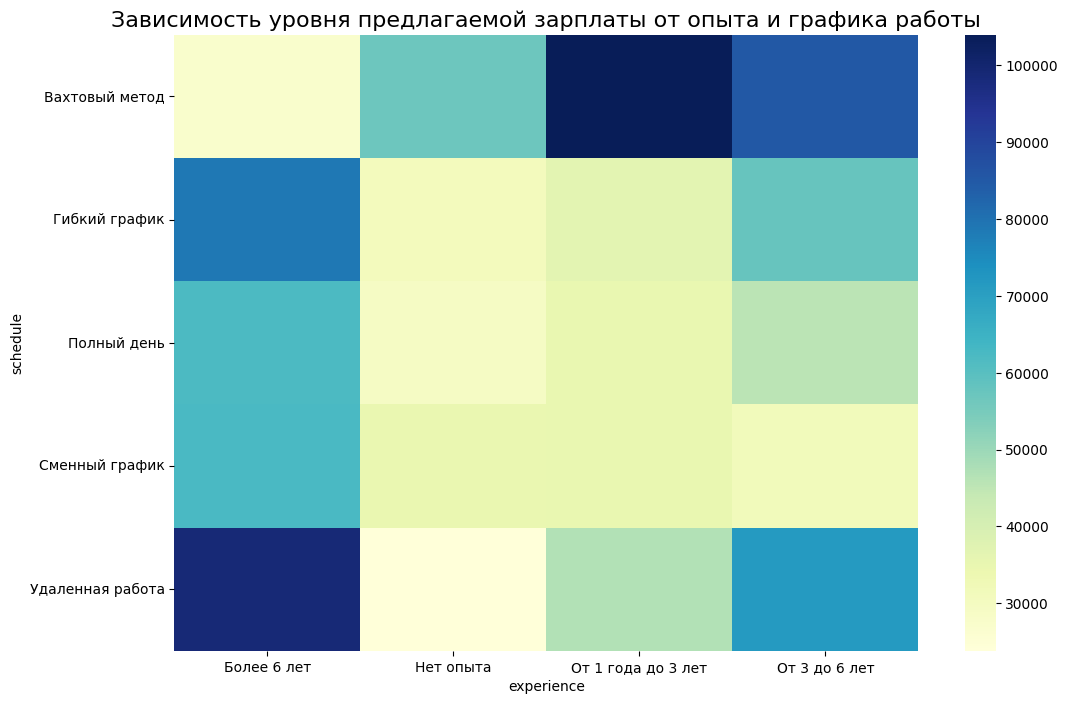

In [153]:
query_7_1 = "SELECT  v.experience,v. schedule, \
            AVG(COALESCE((v.salary_from + v.salary_to) / 2, v.salary_from, v.salary_to, 0)) salary\
            FROM public.vacancies v\
            GROUP BY v.experience, v. schedule"
            
salary_vac_df = query_func(query_7_1)

pyvot_salary = salary_vac_df.pivot_table(values='salary', index='schedule', 
                                   columns='experience', aggfunc='mean')

display(pyvot_salary)

plt.figure(figsize=(12,8))
heatmap_pyvot_salary = sns.heatmap(data=pyvot_salary,
                                   cmap='YlGnBu')
heatmap_pyvot_salary.set_title('Зависимость уровня предлагаемой зарплаты от опыта и графика работы',
                               fontsize=16)

**Вывод:** ожидаемо, что наиболее высокий уровень заработной платы имеют сотрудники с опытом работы более 6 лет и работающие вахтовым методом. Удивительно, что для сотрудников с опытом более 6 лет и вахтовым методом уровень заработной платы значительно ниже, чем при опыте менее 6 лет. !Вероятно, имеет место наличие "неоднородных" вакансий. Необходимо четко разделить вакансии по сферам деятельности и затем отдельно для каждой сферы провести сравнительный анализ!.

### Попробуем провести более углубленный анализ вакансий от Яндекса

In [154]:
# Выберем из вакансий от Яндекса информацию о ключевых навыках, опыте работы, графике работы, тип занятости, 
# уровень средней заработной платы (аналогично заданию 6.6), регион 
query_7_2 = "SELECT  v.id, v.name, v.key_skills, v.experience, v.schedule, v. employment,\
            AVG(COALESCE((v.salary_from + v.salary_to) / 2, v.salary_from, v.salary_to, 0)) salary,\
            a.name area\
            FROM public.vacancies v \
               JOIN public.employers e ON v.employer_id = e.id \
               JOIN public.areas a ON v.area_id = a.id \
            WHERE e.name = 'Яндекс'\
            GROUP BY a.name, v.id"
            
yandex_vac_df = query_func(query_7_2)

In [155]:
display(yandex_vac_df.head())

,id,name,key_skills,experience,schedule,employment,salary,area
0,49060099,Младший специалист ручного тестирования,None,Нет опыта,Удаленная работа,Частичная занятость,0.0,Абакан
1,49077938,Специалист службы поддержки с техническими зна...,None,Нет опыта,Удаленная работа,Частичная занятость,15000.0,Абакан
2,54276929,Специалист службы поддержки в Яндекс Бизнес,None,Нет опыта,Удаленная работа,Полная занятость,26000.0,Абакан
3,54410016,Специалист службы поддержки пользователей,None,Нет опыта,Удаленная работа,Частичная занятость,13000.0,Абакан
4,54444621,Специалист службы поддержки с техническими зна...,None,Нет опыта,Удаленная работа,Частичная занятость,15000.0,Абакан


In [156]:
# оценим вакансии по требованиям к опыту
yandex_vac_exp = yandex_vac_df.groupby(by='experience')['experience'].count()
display(yandex_vac_exp)

fig = go.Figure()

fig.add_trace(go.Histogram(histfunc='sum',x=yandex_vac_exp.index, y=yandex_vac_exp.values))
fig.update_layout(height=500, width = 800, 
                  title='Требования к опыту соискателя')

fig.show()

experience
Более 6 лет              6
Нет опыта             1475
От 1 года до 3 лет     380
От 3 до 6 лет           72
Name: experience, dtype: int64

**Вывод**: в 1475 вакансиях опыт не требуется, 380 вакансий ждля специалистов с опытом работы 1-3года, 72 вакансии для соискателей с опытом 3-6 лет, 6 вакансий для специалистов с опытом более 6 лет

In [157]:
# узнаем медиану зарплат по регионам
salary_area_df = yandex_vac_df[yandex_vac_df['salary'] != 0].groupby(by='area', as_index=False
                                       )['salary'].median().sort_values(by='salary', ascending=False)


display(salary_area_df)

,area,salary
76,Москва,51000.0
128,Санкт-Петербург,46000.0
51,Камышин,42500.0
144,Сыктывкар,34750.0
141,Стерлитамак,34750.0
...,...,...
66,Курган,15000.0
64,Краснодар,15000.0
62,Кострома,15000.0
59,Комсомольск-на-Амуре,15000.0


**Вывод:** Медианная зарплата в компании яндекс зависит от региона. Максимальная - в Москве (51000 рублей), минимальная до 15000 во многих регионах(Курган, Краснодар, Косьтрома и тд)

In [158]:
#ценим предлагаемую заработную плату в зависимости от опыта
data_sul = yandex_vac_df.groupby(by='experience')[['experience', 'salary']].mean()
                                                  
salary_fig = go.Figure()

salary_fig.add_trace(go.Histogram(histfunc='avg',x=data_sul.index, y=yandex_vac_df['salary']))

salary_fig.update_layout(height=500, width = 800, 
                  title='Уровень желаемой зарплаты в зависимости от опыта')
salary_fig.show()

/var/folders/92/r8gb2lm900g2yn2bq6451l280000gn/T/ipykernel_7360/3332463275.py:2: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



**Вывод:** не отмечена прямая зависимость уровня заработной платы от опыта работы. !Вероятно, необходимо провести оценку для каждо категорий специалистов!.

### Для демонстрации влияния "неоднородности" различных сфер деятельности проведем изучение этих же показатели для вакансий из области DS

In [159]:
# за основу возьмем запрос из предудущего задания по Яндекс и требования к DS из блока 6
ds_info = ['%data scientist%', '%data science%','%исследователь данных%', 
           '%машинн%%обучен%%', '%machine learning%']
query_7_3 = f" WITH table_ds AS\
              (SELECT  v.id, v.name, v.key_skills, v.experience, v.schedule, v. employment,\
                      AVG(COALESCE((v.salary_from + v.salary_to) / 2, v.salary_from, v.salary_to, 0)) salary,\
                       a.name area\
               FROM public.vacancies v \
                       JOIN public.employers e ON v.employer_id = e.id \
                       JOIN public.areas a ON v.area_id = a.id \
               WHERE e.name = 'Яндекс'\
               GROUP BY a.name, v.id)\
               \
               SELECT *\
               FROM table_ds\
               WHERE (name ILIKE ANY (array{ds_info})  OR name LIKE '%ML%')\
                           AND name NOT ILIKE '%HTML%'"

yandex_vac_ds_df = query_func(query_7_3)

display(yandex_vac_ds_df.head())        

,id,name,key_skills,experience,schedule,employment,salary,area
0,55338837,ML разработчик в Дзен,Python\tJava\tC++\tАлгоритмы и структуры данны...,От 3 до 6 лет,Полный день,Полная занятость,0.0,Екатеринбург
1,55338816,ML разработчик в Дзен,Python\tJava\tC++\tАлгоритмы и структуры данны...,От 3 до 6 лет,Полный день,Полная занятость,0.0,Казань
2,54593224,Tutor in Data Analysis and Data Science,Английский язык\tData Analysis\tData science,От 1 года до 3 лет,Гибкий график,Частичная занятость,0.0,Москва
3,54888475,ML-инженер в Вертикали,Python\tSQL\tJava\tPandas,От 1 года до 3 лет,Полный день,Полная занятость,0.0,Москва
4,54920334,Data Scientist,Python\tSQL\tLinux\tHadoop\tАнализ данных\tCat...,От 3 до 6 лет,Полный день,Полная занятость,0.0,Москва


In [160]:
# оценим вакансии DS по требованиям к опыту
yandex_vac_ds_exp = yandex_vac_ds_df.groupby(by='experience')['experience'].count()
display(yandex_vac_ds_exp)

fig = go.Figure()

fig.add_trace(go.Histogram(histfunc='sum',x=yandex_vac_ds_exp.index, y=yandex_vac_ds_exp.values))
fig.update_layout(height=400, width = 500, 
                  title='Требования к опыту соискателя для DS')

fig.show()

experience
От 1 года до 3 лет    3
От 3 до 6 лет         6
Name: experience, dtype: int64

**Вывод**: В компанию Яндекс требуются специалисты в DS, которые имеют опыт от 1 до 3 лет (3 вакансии) и еще более 3-6 лет (6 вакансий). Вакансий для Junior и специалистов с опытом более 6 лет нет. Таким образом, в компании Яндекс достаточно высокие требования к уровню опыта для кандидатов по указанной специальности. Специалисты DS с опытом старше 6 лет вообще отсутствуют в вакансиях (как мы отмечали выше), это связано с тем, что их единицы, они известны в данной области и их приглашают на должность адресно.

In [161]:
#ценим предлагаемую заработную плату в зависимости от опыта
data_sul_ds = yandex_vac_ds_df.groupby(by='experience')[['experience', 'salary']].mean()
display(data_sul_ds)                                                

/var/folders/92/r8gb2lm900g2yn2bq6451l280000gn/T/ipykernel_7360/1179947435.py:2: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



,salary
experience,
От 1 года до 3 лет,0.0
От 3 до 6 лет,0.0


**Вывод:** Заработная плата для специалистов DS в компанию Яндекс не указана, что говорит о ее зависимости от результатов собеседования и о том, что кандидатов привлекает имидж компании, а не установленный уровень зарплаты.



### Выводы по результата дополнительного исследования:

- наиболее высокий уровень заработной платы имеют сотрудники с опытом работы более 6 лет и работающие вахтовым методом. Удивительно, что для сотрудников с опытом более 6 лет и вахтовым методом уровень заработной платы значительно ниже, чем при опыте менее 6 лет. Вероятно, имеет место наличие "неоднородных" вакансий. Необходимо четко разделить вакансии по сферам деятельности и затем отдельно для каждой сферы провести сравнительный анализ.

- В вакансиях от Яндкс в 1475 опыт не требуется, 380 вакансий для специалистов с опытом работы 1-3года, 72 вакансии для соискателей с опытом 3-6 лет, 6 вакансий для специалистов с опытом более 6 лет.

- Медианная предполагаемая зарплата в компании яндекс зависит от региона. Максимальная - в Москве (51000 рублей), минимальная до 15000 во многих регионах(Курган, Краснодар, Кострома и тд).

- Не отмечена прямая зависимость уровня заработной платы от опыта работы. 

**Данный факт требует демонстрации зависимоти показателей по вакансиям для отдельных сфер деятельности**
   
- В компанию Яндекс требуются специалисты в DS, которые имеют опыт от 1 до 3 лет (3 вакансии) и еще более 3-6 лет (6 вакансий). Вакансий для Junior и специалистов с опытом более 6 лет нет. Таким образом, в компании Яндекс достаточно высокие требования к уровню опыта для кандидатов по указанной специальности. Специалисты DS с опытом старше 6 лет вообще отсутствуют в вакансиях (как мы отмечали выше), это связано с тем, что их единицы, они известны в данной области и их приглашают на должность адресно.

- Заработная плата для специалистов DS в компанию Яндекс не указана, что говорит о ее зависимости от результатов собеседования и о том, что кандидатов привлекает имидж компании, а не установленный уровень зарплаты.

**Продемонстрированные результаты указывают на значительные отличия для каждой профессиональной сферы и на то что нельзя ориентироваться на обобщенные данные.**